In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

#  1. Импорт данных, предварительные обработка и исследование

## 1.1 Импорт данных

In [108]:
#  Получение ссылки на скачивание
import requests 
from urllib.parse import urlencode 

def get_url_disk(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    download_response = requests.get(download_url) 
    return download_url

public_key_customers = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg' 
public_key_orders = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
public_key_items = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

In [109]:
# Импорт данных
customers = pd.read_csv(get_url_disk(public_key_customers))
orders = pd.read_csv(get_url_disk(public_key_orders))
items = pd.read_csv(get_url_disk(public_key_items))

In [110]:
# Импорт данных если закончились скачивания
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')

## 1.2 Исследование данных о пользователях

In [111]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Возможно, наша кампания работает в Бразилии

In [112]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [113]:
# проверка на нули
check_null_cast = customers.isnull().sum()
check_null_cast

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [114]:
# количество уникальных customer_id (проверка на дубли)
customers.customer_id.nunique()

99441

In [115]:
# количество уникальных customer_unique_id
customers.customer_unique_id.nunique()

96096

Как видно, количество уникальных customer_id соответствует кол-ву строк DF customers, в то время как количество уникальных "паспортов" (customer_unique_id) меньше этого числа.
**Следовательно**, кто-то зарегестрировался на один "паспорт" несколько раз. Посмотрим кто и в каком количестве.

In [116]:
customers \
    .groupby('customer_unique_id', as_index = False) \
    .agg({'customer_id' : 'count'}) \
    .rename(columns = {'customer_id' : 'count_customers'}) \
    .query('count_customers > 1') \
    .sort_values('count_customers', ascending = False)

,customer_unique_id,count_customers
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17
23472,3e43e6105506432c953e165fb2acf44c,9
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7
37797,6469f99c1f9dfae7733b25662e7f1782,7
76082,ca77025e7201e3b30c44b472ff346268,7
...,...,...
33730,597e54e653cbc1ce5df1e6d97bbc448c,2
33755,598ef1f13aba15f2b88387184f6c25ec,2
33829,59bba92de9b8f6be0808e4d9d64b4b43,2
33867,59d66d72939bc9497e19d89c61a96d5f,2


Оценим насколько масштабное явление - регистрация нескольких аккаунтов на 1 "паспорт", т.е. в наших данных 2997 пользователей имеют несколько аккаунтов

In [117]:
2997/96096*100 

3.1187562437562435

что составляет **3,1%** от всех пользователей

In [118]:
customers \
    .groupby('customer_unique_id', as_index = False) \
    .agg({'customer_id' : 'count'}) \
    .rename(columns = {'customer_id' : 'count_customers'}) \
    .query('count_customers > 1') \
    .sort_values('count_customers', ascending = False) \
    .count_customers.sum()/99441*100
#  и 6.4% от всех аккаунтов

6.377651069478383

In [119]:
# посмотрим на географические характеристиики наших пользователей
# количество уникальных customer_zip_code_prefix
customers.customer_zip_code_prefix.nunique()

14994

In [120]:
# количество уникальных customer_city
customers.customer_city.nunique()

4119

In [121]:
# количество уникальных customer_state
customers.customer_state.nunique()

27

## 1.3 Исследование данных о заказах

In [122]:
# Приведение дат в соответствующие форматы
orders.order_purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp, yearfirst = True)
orders.order_approved_at = pd.to_datetime(orders.order_approved_at, yearfirst = True)
orders.order_delivered_carrier_date = pd.to_datetime(orders.order_delivered_carrier_date, yearfirst = True)
orders.order_delivered_customer_date = pd.to_datetime(orders.order_delivered_customer_date, yearfirst = True)
orders.order_estimated_delivery_date = pd.to_datetime(orders.order_estimated_delivery_date, yearfirst = True)
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [123]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [124]:
# количество уникальных order_id соответсвует кол-ву строк в DF orders (проверка на дубли)
all_orders = orders.order_id.nunique()
all_orders

99441

In [125]:
# проверка на нули
check_null_ord = orders.isnull().sum()
check_null_ord

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [126]:
# Статусы заказа:
order_status_count = orders \
    .groupby('order_status', as_index = False) \
    .agg({'order_id' : 'count'}) \
    .rename(columns = {'order_id' : 'status_count'})
order_status_count

,order_status,status_count
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [127]:
# посмотрим на отмененные заказы. 
cancel_orders = orders.query('order_status == "canceled"')
struct_cancel_orders = cancel_orders[['order_purchase_timestamp', 
               'order_approved_at', 
               'order_delivered_carrier_date', 
               'order_delivered_customer_date', 
               'order_estimated_delivery_date']] \
    .isnull().sum() \
    .to_frame().reset_index() \
    .rename(columns =  {0 : 'increscent_count'})
struct_cancel_orders

,index,increscent_count
0,order_purchase_timestamp,0
1,order_approved_at,141
2,order_delivered_carrier_date,550
3,order_delivered_customer_date,619
4,order_estimated_delivery_date,0


В таблице наверху итог нарастающий.
Таким образом, всего отмененных заказов - 625 (0.64% от всех завершенных заказов (cancelled+delivered)), среди них:
- **141 (22,6 % от всех отмен)** - отменены до оплаты заказа;
- **550-141= 409 (65,4% от всех отмен)** - отменены до передачи заказа в доставку;
- **619 - 550 = 69 (11,0% от всех отмен)** - отменены до того как были доставлены;
- **625 - 619 = 6 (1,0% от всех отмен)** - отменены после доставки

Кроме этого видно, что ожидаемое время доставки (order_estimated_delivery_date) оценивается (появляется) сразу после оформления заказа.

In [128]:
# посмотрим, есть ли незаполненные поля в заказах со статусом delivered:
orders \
    .query('order_status == "delivered"') \
    .isnull() \
    .sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

Как видно из данных выше небольшое количество заказов со статусом **delivered** имеет незаполненные поля, которых быть не должно. 

In [129]:
# посмотрим на заказы с статусом "unavailable"
unavailible_orders = orders.query('order_status == "unavailable"')
unavailible_orders[['order_purchase_timestamp', 
               'order_approved_at', 
               'order_delivered_carrier_date', 
               'order_delivered_customer_date', 
               'order_estimated_delivery_date']] \
    .isnull().sum().to_frame()

,0
order_purchase_timestamp,0
order_approved_at,0
order_delivered_carrier_date,609
order_delivered_customer_date,609
order_estimated_delivery_date,0


заказы unavailible все были остановлены до передачи в доставку, но после оплаты. 

## 1.4 Исследование данных о заказанных товарах

In [130]:
# Приведение даты в соответствующие формат
items.shipping_limit_date = pd.to_datetime(items.shipping_limit_date, yearfirst = True)
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [131]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [132]:
# проверка на нули
check_null_items = items.isnull().sum()
check_null_items

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [133]:
# посмотрим на заказы отмененные после доставки, дополнительно подгрузив информацию из DF items
orders_canc_after_deliv = orders \
    .query('order_status == "canceled"') \
    .query('order_delivered_customer_date.notnull()', engine='python') \
    .merge(items, how = 'inner', on = 'order_id')

#  посчитаем разницу между ожидаемым и фактическим временем доставки:
orders_canc_after_deliv['date_diff_estim_custom'] = orders_canc_after_deliv.order_estimated_delivery_date - orders_canc_after_deliv.order_delivered_customer_date

#  посчитаем разницу между предельным и фактическим временем доставки:
orders_canc_after_deliv['date_diff_limit_custom'] = orders_canc_after_deliv.shipping_limit_date - orders_canc_after_deliv.order_delivered_customer_date                        
orders_canc_after_deliv[['order_id', 'order_status', 
                         'order_purchase_timestamp', 
                         'order_delivered_customer_date', 
                         'order_estimated_delivery_date',
                         'shipping_limit_date',
                        'date_diff_estim_custom', 
                         'date_diff_limit_custom']]

,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,date_diff_estim_custom,date_diff_limit_custom
0,1950d777989f6a877539f53795b4c3c3,canceled,2018-02-19 19:48:52,2018-03-21 22:03:51,2018-03-09,2018-02-23 20:56:05,-13 days +01:56:09,-27 days +22:52:14
1,dabf2b0e35b423f94618bf965fcb7514,canceled,2016-10-09 00:56:52,2016-10-16 14:36:59,2016-11-30,2016-10-13 13:36:59,44 days 09:23:01,-4 days +23:00:00
2,dabf2b0e35b423f94618bf965fcb7514,canceled,2016-10-09 00:56:52,2016-10-16 14:36:59,2016-11-30,2016-10-13 13:36:59,44 days 09:23:01,-4 days +23:00:00
3,770d331c84e5b214bd9dc70a10b829d0,canceled,2016-10-07 14:52:30,2016-10-14 15:07:11,2016-11-29,2016-10-11 15:07:11,45 days 08:52:49,-3 days +00:00:00
4,8beb59392e21af5eb9547ae1a9938d06,canceled,2016-10-08 20:17:50,2016-10-19 18:47:43,2016-11-30,2016-10-13 14:34:31,41 days 05:12:17,-7 days +19:46:48
5,65d1e226dfaeb8cdc42f665422522d14,canceled,2016-10-03 21:01:41,2016-11-08 10:58:34,2016-11-25,2016-10-21 16:24:43,16 days 13:01:26,-18 days +05:26:09
6,2c45c33d2f9cb8ff8b1c86cc28c11c30,canceled,2016-10-09 15:39:56,2016-11-09 14:53:50,2016-12-08,2016-10-14 10:40:50,28 days 09:06:10,-27 days +19:47:00


Как видно только один из отменных после доставки заказов был доставлен после ожидаемой даты доставки (order_estimated_delivery_date	). В то время как все заказы из отмененных после доставки были доставлены позже, чем дата определенная продавцом как предельная (shipping_limit_date).

Следовательно, причина такого рода отмен - превышение предельного времени доставки (shipping_limit_date). Кроме того даже ожидаемое время доставки во всех случаях оказалось больше предельного времени доставки. 

Так как ожидаемое время доставки оценивается в момент создания заказа (что видно исходя из проверки на нули DF orders), то можно легко избегать подобных отмен сравнивая ожидаемое время с предельным временем доставки в момент совершения заказа.

In [134]:
# количество заказанных уникальных продуктов
items.product_id.nunique()

32951

In [135]:
# количество  уникальных продавцов
items.seller_id.nunique()

3095

In [136]:
# есть ли товары с 0 ценой?
items \
    .query('price == 0')
# нет

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


In [137]:
# есть ли товары с 0 весом?
null_weight = items \
    .query('freight_value == 0')
null_weight.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
114,00404fa7a687c8c44ca69d42695aae73,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-15 04:31:26,99.9,0.0
258,00a870c6c06346e85335524935c600c0,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-05-14 00:14:29,69.9,0.0
483,011c899816ea29773525bd3322dbb6aa,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-07 05:30:45,99.9,0.0
508,012b3f6ab7776a8ab3443a4ad7bef2e6,1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-09 21:30:50,53.9,0.0
509,012b3f6ab7776a8ab3443a4ad7bef2e6,2,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-09 21:30:50,53.9,0.0


In [138]:
# сколько видов товаров с 0 весом
null_weight \
    .groupby('product_id', as_index = False) \
    .agg({'order_id' : 'count'})

,product_id,order_id
0,2a34e0af5f72ca6cdeb148377a247c86,1
1,2b4609f8948be18874494203496bc318,1
2,422879e10f46682990de24d770e7f83d,56
3,4fcb3d9a5f4871e8362dfedbdb02b064,1
4,53b36df67ebb7c41585e8d54d6772e08,187
5,5a848e4ab52fd5445cdc07aab1c40e48,2
6,7a10781637204d8d10485c71a6108a2e,27
7,81fe540cb0119e1d4ef5f191701b3cb9,1
8,aca2eb7d00ea1a7b8ebd4e68314663af,98
9,f1c7f353075ce59d8a6f3cf58f419c9c,9


In [139]:
#  стоимость заказов:
items \
    .groupby('order_id', as_index = False) \
    .agg({'price' : 'sum'}) \
    .rename(columns = {'price' : 'revenue'}) \
    .sort_values('revenue', ascending = False)

,order_id,revenue
1455,03caa2c082116e1d31e67e9ae3700499,13440.00
44467,736e1922ae60d0d6a89247b851902527,7160.00
3130,0812eb902a67711a1cb742b3cdaa65ae,6735.00
98298,fefacc66af859508bf1a7934eab1e97f,6729.00
94439,f5136e38d1a14a4dbd87dff67da82701,6499.00
...,...,...
21805,38bcb524e1c38c2c1b60600a80fc8999,2.90
89758,e8bbc1d69fee39eee4c72cb5c969e39d,2.29
93208,f1d5c2e6867fa93ceee9ef9b34a53cbf,2.20
24174,3ee6513ae7ea23bdfab5b9ab60bffcb5,0.85


In [140]:
# количество заказанных товаров
items \
    .groupby('product_id', as_index = False) \
    .agg({'order_item_id' : 'count'}) \
    .rename(columns = {'order_item_id' : 'quant'}) \
    .sort_values('quant', ascending = False)

,product_id,quant
22112,aca2eb7d00ea1a7b8ebd4e68314663af,527
19742,99a4788cb24856965c36a24e339b6058,488
8613,422879e10f46682990de24d770e7f83d,484
7364,389d119b48cf3043d311335e499d9c6b,392
7079,368c6c730842d78016ad823897a372db,388
...,...,...
14037,6ca99f05e9c1952a6597264e87f01378,1
14036,6ca54e191592a843087a042b0665d7ef,1
14035,6ca5428af5edb5066b1966ad58501b60,1
14034,6ca32b4631431cb1fe976880797a0f5c,1


Как видно количество уникальных продуктов и количество строк в таблице выше совпадают. 

## 1.5 Выводы по разделу:

1. Количество уникальных customer_id и order_id совпадают. На один customer_id приходится один order_id? - Да (обоснование выводв в п.2.1).
2. По данной части можно определится с тем, что считать покупкой. В некотором роде ответ зависит от ответов на ряд вопросов:
    1)  Что важнее, точность расчета (выручки и др.показателей) или скорость поступления данных?
Чем более ранее событие выбираем, тем меньше временной люфт от момента заказа до признания заказа покупкой, но тем больше погрешность расчетов.
Первый крайний случай, если мы признаем покупкой заказ в момент его создания заказа, то временной люфт равен 0 и мы можем следить за выручкой и пр. в режиме реального времени, но погрешность максимальна: ее создают все отмененные заказы и заказы, закрытые из-за отсутствия товаров.
Другой крайний случай, когда покупкой считается заказ в момент его доставки покупателю. Точность максимальна (погрешность создают заказы отмененные после доставки). Временной люфт составляет время необходимое на все стадии заказа от обраотки до доставки.
    2) Входит служба доставки в нашу кампанию, или кампания отдает эту функцию на аутсорс?
Другими словами чья ответственность и насколько критично увеличение погрешности. Так как, по-видимому, наша кампания - что-то типа маркетплейса, где много продавцов используют общую платформу. Обычно такие кампании организуют собственные службы доставки, поэтому в дальнейшем я буду считать, что служба доставки - часть нашей кампании. 
3. Есть заказы с статусом delivered  в которых пропущены даты оплаты, доставки до службы и клиенту. Их реальный статус не ясен и из дальнейших расчетов их стоит исключить
4. Во всех заказах отмененных после доставки превышен предельный срок доставки, как ожидаемый так и фактический. Данной проблемы можно избежать сравнивая ожидаемую дату доставки с предельной в момент заказа

In [141]:
#  Чтобы выбрать что считать покупкой оценим погрешность подсчета количетва заказов по всей выборке (по всему DF orders) относительно завершенных заказов
# в двух крайних случаях:
    #  -- Покупкой считается заказ в момент создания:
            # Количество заказов не учитываемое при приравнивании покупки к моменту создания заказа (не учитываем отмены и недоступные заказы)
canc_and_unavalible_orders = order_status_count.query('order_status == "canceled"').status_count.to_list()[0] \
    + order_status_count.query('order_status == "unavailable"').status_count.to_list()[0]
            # Расчет ошибки в %
creation_error = canc_and_unavalible_orders /  all_orders* 100
creation_error

1.2409368369183738

In [142]:
    # -- Покупкой считается заказ в момент доставки
        #  Общее количество завершенных заказов (вычитаем из общего кол-ва все незавершенные статусы):
completed_orders = (all_orders 
                    - order_status_count.query('order_status == "approved"').status_count.to_list()[0]
                    - order_status_count.query('order_status == "created"').status_count.to_list()[0]
                    - order_status_count.query('order_status == "invoiced"').status_count.to_list()[0] 
                    - order_status_count.query('order_status == "processing"').status_count.to_list()[0] 
                    - order_status_count.query('order_status == "shipped"').status_count.to_list()[0])   
        # Количество заказов не учитываемое при приравнивании покупки к моменту доставки заказа (отмененные после доставки не учитываются)
canc_after_deliv = order_status_count.query('order_status == "canceled"').status_count.to_list()[0]  \
    - struct_cancel_orders.query('index == "order_delivered_customer_date"').increscent_count.to_list()[0]    
            # Расчет ошибки в %
delivery_error = canc_after_deliv / completed_orders * 100
delivery_error

0.006140494514491567

Из оценочного расчета ошибки видно, что точность расчетов при переходе от первого варианта ко второму возрастает более чем на 3 порядка.
Так как временной фактор не важен стоит выбрать наиболее точный вариант, т.е. принимаем, что **покупкой считается доставленный заказ**

Кроме того даже при фильтрации по статусу нужно помнить об ошибочных заказах, статус которых delivered, но часть полей которых не заполнена.
Для дальнейших расчетов **по покупкам** будем использовать следующий поправленный DF по выполненным покупкам:

In [143]:
orders_delivered_corrected = orders \
    .query('order_status == "delivered"') \
    .dropna()
orders_delivered_corrected

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15


# 2. Ответы на вопросы задания


## 2.1 Сколько у нас пользователей, которые совершили покупку только один раз?

Как видно из предварительного исследования данных с каждого **customer_id** была совершена только одна покупка, так что в качестве покупателя будем рассматривать **customer_unique_id**

In [144]:
# Сколько покупателей (customer_unique_id), которые совершили покупку один раз:
one_buy_uniq_id = orders_delivered_corrected \
    .merge(customers, how = 'inner', on = 'customer_id') \
    .query('order_status == "delivered"') \
    .groupby('customer_unique_id', as_index = False) \
    .agg({'order_id' : 'count'}) \
    .rename(columns = {'order_id' : 'count_orders_per_cust'}) \
    .query('count_orders_per_cust == 1') \
    .shape[0]
one_buy_uniq_id

90536

## 2.2 Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Считать среднее значение в месяц для недоставленных заказов имеет смысл только для заказов с каким-то завершенным статусом, который не будет меняться в дальнейшем. В нашем случае это статусы canceled и unavailable.

Заказы с промежуточным статусом (например, approved, processing и пр.), во-первых, могут меняться в дальнейшем, а, во-вторых, будут иметь явновыраженный максимум в последний временной период. Возможно, стоит контроллировать абсолютное количество таких заказов, но никак не среднее по месяцам.

In [145]:
# Для того, чтобы учесть в статистике все заказы используем дату создания заказа.
# Создаем DF для решения
reasons_non_delivery = orders \
    .copy() \
    [['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp']]
# Приводим дату к началу месяца
reasons_non_delivery['month'] = reasons_non_delivery['order_purchase_timestamp'] \
    .to_numpy() \
    .astype('datetime64[M]')
# Считаем отмены и недоступные заказы по месяцам
reasons_non_delivery = reasons_non_delivery\
    .query('order_status == "canceled" or order_status == "unavailable"') \
    .groupby(['month', 'order_status']) \
    .agg({'order_id' : 'count'}) \
    .rename(columns = {'order_id' : 'count_orders'}) \
    .reset_index() \
    .pivot(index = 'month', columns = 'order_status', values = 'count_orders') \
    .fillna(0)
# создаем колонку с суммой отмен:
reasons_non_delivery['all_non_delivered'] = reasons_non_delivery.canceled + reasons_non_delivery.unavailable
# считаем средние значения по недоставленным заказам в общем и по отдельным причинам (canceled и unavailable)
reasons_non_delivery \
    .mean() \
    .round(2) \
    .to_frame()

,0
order_status,
canceled,26.04
unavailable,25.38
all_non_delivered,51.42


## 2.3 По каждому товару определить, в какой день недели товар чаще всего покупается.

Так как время обработки и доставки может варьироваться, датой покупки будем считать дату создания заказа (**order_purchase_timestamp**), однако, учитывать будем только те заказы, статус которых **delivered** (DF orders_delivered_corrected)

Кроме этого, стоит учесть, что может быть несколько дней с максимальным количеством заказов

In [146]:
# Создаем DF для решения
most_freq_day = orders_delivered_corrected \
    .copy() \
    [['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp']] \
    .merge(items, how = 'inner', on = 'order_id')
# извлекаем день недели из даты заказа
most_freq_day['day'] = most_freq_day.order_purchase_timestamp \
    .dt.day_name()
# считаем сколько заказов в какой день сделано
most_freq_day = most_freq_day \
    .groupby(['product_id', 'day'], as_index = False) \
    .agg({'order_id' : 'count'}) \
    .rename(columns = {'order_id' : 'count_orders'}) \
    .sort_values('count_orders', ascending = False)
# определяем максимальное количество товаров:
max_orders = most_freq_day \
    .groupby('product_id', as_index = False) \
    .agg({'count_orders' : 'max'})
# определяем наиболее популярный день/дни (объединяем таблицы most_freq_day и max_orders):
most_freq_day = most_freq_day \
    .merge(max_orders, how = 'inner', on = ['product_id', 'count_orders'])
most_freq_day

,product_id,day,count_orders
0,422879e10f46682990de24d770e7f83d,Wednesday,93
1,99a4788cb24856965c36a24e339b6058,Monday,91
2,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
3,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
4,368c6c730842d78016ad823897a372db,Friday,67
...,...,...,...
41762,641444946fe3a839d726c32804cd1aff,Tuesday,1
41763,6416e0ecd625ef4adf18658a9aca2e10,Thursday,1
41764,64187b994e1b15e6a59a6f72688fbea8,Friday,1
41765,64187b994e1b15e6a59a6f72688fbea8,Thursday,1


In [147]:
#  есть ли товары которые одинаково часто покупают в несколько дней недели?
most_freq_day \
    .groupby('product_id', as_index = False) \
    .agg({'day' : 'count'}) \
    .rename(columns = {'day' : 'count_most_popular_days'}) \
    .sort_values('count_most_popular_days')

,product_id,count_most_popular_days
0,00066f42aeeb9f3007548bb9d3f33c38,1
20092,9ffab56dff7071396d82c4b372e7f033,1
20091,9ff8568dfb9041b898e65ff4018c8c57,1
20090,9ff6b4148d8ade1b7b0d281f9de4447e,1
20089,9ff668529410eefd5bca723acb4834c1,1
...,...,...
18638,94950d6ddd0b24c0d15f7f09d61a8148,6
17396,8a8d870b168dfa470a5f28efab92145d,6
25648,cbb702235ad267cca951499fa8475606,6
19610,9c31382f02ac001fe1a33a466471d98c,7


Как видно из этой таблицы есть товары, которые равномерно покупают в течение недели, а есть товары определенной "сезонностью" в течение недели.

## 2.4 Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

Так как время обработки и доставки может варьироваться, датой покупки будем считать дату создания заказа (**order_purchase_timestamp**), однако, учитывать будем только те заказы, статус которых **delivered**

In [148]:
# Разобьем вопрос на 2 части:
        # 1) Сколько у каждого аккаунта (customer_id) в среднем покупок в неделю (по месяцам)?:
                # Создаем DF для вычислений 
average_week_buys_1 =  orders_delivered_corrected\
    .copy() \
    [['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp']]
                #создаем колонку  с датой приведенной к началу месяца
average_week_buys_1['month'] = average_week_buys_1['order_purchase_timestamp'] \
    .to_numpy() \
    .astype('datetime64[M]')
                # Считаем сколько заказов в месяц было у каждого аккаунта  
average_week_buys_1 = average_week_buys_1 \
    .groupby(['customer_id', 'month'], as_index = False) \
    .agg({'order_id' : 'count'}) \
    .rename(columns = {'order_id' : 'count_per_month'})

            # Считаем сколько в среднем покупок в неделю
average_week_buys_1['avg_count_per_week'] = (average_week_buys_1.count_per_month/average_week_buys_1.month.dt.days_in_month * 7) .round(2)
average_week_buys_1.sort_values('count_per_month', ascending = False)

,customer_id,month,count_per_month,avg_count_per_week
0,00012a2ce6f8dcda20d059ce98491703,2017-11-01,1,0.23
64300,aa5e0a0c36015d39de864189a2b00b09,2018-08-01,1,0.23
64309,aa6190994371836fc1d4596edd827abd,2017-12-01,1,0.23
64308,aa606152f23a5fa9ba3d0b87f7a492e8,2018-01-01,1,0.23
64307,aa601b3c45980c0918042d5ca7a25054,2018-03-01,1,0.23
...,...,...,...,...
32150,5585e81d18619898a7ee6517d67cce6b,2018-04-01,1,0.23
32149,5585bc3f707bf7755cc669076c92b15d,2018-07-01,1,0.23
32148,55858b24b1b18a4e50fce22b11a761bf,2017-05-01,1,0.23
32147,5584b1ace8b18cc156ce51b989fd2958,2018-05-01,1,0.23


In [149]:
        # 2) Сколько у каждого покупателя (customer_unique_id) в среднем покупок в неделю (по месяцам)? 
            #     (Напоминаю: у каждого пользователя может быть несколько аккаунтов):
average_week_buys_2 =  orders_delivered_corrected \
    .copy() \
    [['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp']] \
    .merge(customers, how = 'inner', on = 'customer_id')
                #создаем колонку  с датой приведенной к началу месяца
average_week_buys_2['month'] = average_week_buys_2['order_purchase_timestamp'] \
    .to_numpy() \
    .astype('datetime64[M]')
                # Считаем сколько заказов в месяц было у каждого аккаунта  
average_week_buys_2 = average_week_buys_2 \
    .groupby(['customer_unique_id', 'month'], as_index = False) \
    .agg({'order_id' : 'count'}) \
    .rename(columns = {'order_id' : 'count_per_month'})

            # Считаем сколько в среднем покупок в неделю
average_week_buys_2['avg_count_per_week'] = (average_week_buys_2.count_per_month/average_week_buys_2.month.dt.days_in_month * 7).round(2)
average_week_buys_2.sort_values('count_per_month', ascending = False)

,customer_unique_id,month,count_per_month,avg_count_per_week
7099,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-01,6,1.35
74543,c8460e4251689ba205045f3ea17884a1,2018-08-01,4,0.90
23216,3e43e6105506432c953e165fb2acf44c,2018-02-01,4,1.00
65757,b08fab27d47a1eb6deda07bfd965ad43,2017-09-01,4,0.93
14054,25a560b9a6006157838aab1bdbd68624,2017-04-01,4,0.93
...,...,...,...,...
31892,55a44284e2c362a0199fb0df3ea9fb7d,2017-09-01,1,0.23
31891,55a36ff7f14abc01688647c613b35836,2017-12-01,1,0.23
31890,55a36fca00cebb9272a8e7d5b8325f59,2017-05-01,1,0.23
31889,55a34f9f352e3c1ef564fc7855a1b7e9,2018-07-01,1,0.23


## 2.5 Используя pandas, проведи когортный анализ пользователей. 

### В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

В наших данных только 2017 год представлен полностью, поэтому будем рассматривать данный период.

На мой взгляд условие можно интерпретировать 2мя способами:
1) нужно посчитать retention rate для каждой когорты **на конец третьего месяца** и выявить когорту с наибольшим retention rate
2) нужно посчитать retention rate для каждой когорты **для каждого месяца** после первой покупки и выявить когорту, которой самы большой retention на **3й месяц**

Кроме того есть некоторые особенности в той логике расчетов, которые можно провести для того, чтобы посчитать retention rate:

**1 способ:**
- разделить покупателей на когорты по дате первой покупки и посчитать кол-во покупателей в каждой когорте
- выявлять и считать покупателей совершивших повторные покупки в каждом месяце после покупки
- посчитать retention rate за период (месяц) как отношение покупателей совершивших повторные покупки в каждом последующем месяце к общему количеству покупателей в когорте

Мне кажется у данного способа есть минус, который лучше всего проиллюстрировать на примере:
Допустим у нас есть два покупателя, первый совершил покупку 1 января, а второй 31 января. Очевидно, что если мы будем делить покупателей на когорты по месяцу первой покупки, эти два покупателя попадут в одну когорту. Если мы будем считать retention rate за месяц как повторные покупки в феврале, то эти два покупателя будут в разных условиях: у первого с момента первой покупки к февралю пройдет 30-58 дней, у второго 1-28. Кроме этого можно упустить покупки первого покупателя совершенные в январе.

Возможно 1 способ нагляднее и удобнее для бизнеса, но тут у меня совсем нет опыта и рассуждать я не могу.

**2 способ:**
- разделить покупателей на когорты по дате первой покупки и посчитать кол-во покупателей в каждой когорте
- выявить покупателей, которые совершали повторные покупки и посчитать TimeDelta между повторной покупкой/ами и первой
- отфильтровать покупателей по выбранному диапазону/ам TimeDelta (например от 0 до 30 дней, что ~ эквивалентно календарному месяцу) и посчитать их
- посчитать retention rate за период (месяц) как отношение покупателей совершивших повторные покупки в выбранных диапазонах к общему количеству покупателей в когорте

Этот подход лишен описанного выше недостаткаа 1 способа. Вне зависимости от того в начале или в конце временного периода, по которому создается когорта, покупатель совершил покупку можно посчитать retention rate за период, который будет одинаков для каждого покупателя.

Исходя из описанных выше рассуждений я сформулировала параметры для проведения когортного анализа:

**Признак формирования когорты:** первая покупка;

**Размер когорты (временной интервал):** месяц;

**Отчетный период:** январь 2017 - декабрь 2017 ;

**Анализируемый показатель:** retention rate на 1 месяц (0-30 дней), 2 месяц (31-60 дней), 3 месяц (61-90 дней) и общий  retention rat на конец 3его месяца (0-90 дней);

**Способ расчета показателя:** 2 способ


Так как, **с каждого аккаунта (customer_id) была сделана только одна покупка** и посчитать retention rate по аккаунтам невозможно. Стоит попытаться посчитать retention rate используя в качестве идентификатора **"паспорт" (customer_unique_id)**

PS: вообще очень странная ситуация... или каждый покупатель заводит отдельный аккаунт под каждую покупку, либо фактически в системе customer_id и order_id выполняют одну и ту же функцию - ID заказа.... 

In [150]:
# Определим дату первой покупки для каждого покупателя (customer_unique_id) и разделим покупателей по когортам по признаку первой покупки в какой-то месяц
date_first_buy = orders_delivered_corrected \
    .merge(customers, on = 'customer_id', how = 'inner') \
    .groupby('customer_unique_id', as_index = False) \
    .agg({'order_purchase_timestamp' : 'min'}) \
    .rename(columns = {'order_purchase_timestamp' : 'date_first_buy'}) \
    .sort_values('date_first_buy')
date_first_buy['month'] = date_first_buy['date_first_buy'].to_numpy().astype('datetime64[M]')
date_first_buy['cohort'] = date_first_buy['date_first_buy'].dt.strftime('%Y-%m')
date_first_buy

,customer_unique_id,date_first_buy,month,cohort
47873,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15 12:16:38,2016-09-01,2016-09
18605,32ea3bdedab835c3aa6cb68ce66565ef,2016-10-03 09:44:50,2016-10-01,2016-10
17357,2f64e403852e6893ae37485d5fcacdaf,2016-10-03 16:56:50,2016-10-01,2016-10
35804,61db744d2f835035a5625b59350c6b63,2016-10-03 21:13:36,2016-10-01,2016-10
51390,8d3a54507421dbd2ce0a1d58046826e0,2016-10-03 22:06:03,2016-10-01,2016-10
...,...,...,...,...
44582,7a22d14aa3c3599238509ddca4b93b01,2018-08-29 12:25:59,2018-08-01,2018-08
33806,5c58de6fb80e93396e2f35642666b693,2018-08-29 14:18:23,2018-08-01,2018-08
46730,7febafa06d9d8f232a900a2937f04338,2018-08-29 14:18:28,2018-08-01,2018-08
66809,b701bebbdf478f5500348f03aff62121,2018-08-29 14:52:00,2018-08-01,2018-08


In [151]:
# Считаем количество пользователей (customer_unique_id) в каждой когорте:
count_cohort_customers = date_first_buy \
    .groupby('cohort', as_index = False) \
    .agg({'customer_unique_id' : 'count'}) \
    .rename(columns = {'customer_unique_id' : 'count_customer_unique_id'}) \
    .sort_values('cohort')
count_cohort_customers

,cohort,count_customer_unique_id
0,2016-09,1
1,2016-10,262
2,2016-12,1
3,2017-01,715
4,2017-02,1616
5,2017-03,2503
6,2017-04,2256
7,2017-05,3450
8,2017-06,3037
9,2017-07,3752


In [152]:
# объединяем таблицы для дальнейших расчетов
orders_merged = orders_delivered_corrected \
    .merge(customers, on = 'customer_id', how = 'inner') \
    .merge(date_first_buy, on = 'customer_unique_id', how = 'inner')
orders_merged

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,date_first_buy,month,cohort
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-09-04 11:26:38,2017-09-01,2017-09
1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-09-04 11:26:38,2017-09-01,2017-09
2,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07-24 20:41:37,2018-07-01,2018-07
3,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08-08 08:38:49,2018-08-01,2018-08
4,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11-18 19:28:06,2017-11-01,2017-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96450,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017-03-09 09:54:05,2017-03-01,2017-03
96451,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,2018-02-06 12:58:58,2018-02-01,2018-02
96452,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,2017-08-27 14:46:43,2017-08-01,2017-08
96453,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2018-01-08 21:28:27,2018-01-01,2018-01


In [153]:
# определяем данные последующих покупок
second_buys = orders_merged \
    .copy() \
    .query('order_purchase_timestamp > date_first_buy')
# считаем TimeDelta с момента первой покупки
second_buys['time_after_first_buy'] = second_buys['order_purchase_timestamp'] - second_buys['date_first_buy']
second_buys.sort_values('time_after_first_buy')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,date_first_buy,month,cohort,time_after_first_buy
26401,e23384b25f3ef1f0ff7d8f2b23b01842,3c211334433c8e120deadcddac8c34eb,delivered,2018-01-28 18:04:29,2018-01-28 18:14:22,2018-01-30 00:16:47,2018-02-03 13:32:51,2018-03-02,d0e376592a3036444738ee6a426785c1,4675,sao paulo,SP,2018-01-28 18:04:28,2018-01-01,2018-01,0 days 00:00:01
5089,28136596c0ceb5c43000c1776348b72b,0761a5ba0468e259dcc1cff863eeb3a9,delivered,2018-03-13 06:48:40,2018-03-13 07:27:46,2018-03-27 23:38:53,2018-04-19 20:19:20,2018-04-19,e1407f4d2fd92ed069307bb0b836615a,65800,balsas,MA,2018-03-13 06:48:39,2018-03-01,2018-03,0 days 00:00:01
30953,d708b88543d7c2b7c9eb0b31864c8ca1,f60c95ed2b10ddd5ce8c6a25240edda9,delivered,2017-02-05 23:52:10,2017-02-06 01:05:37,2017-02-20 07:14:11,2017-02-23 15:07:38,2017-03-10,d451891847b64bb4cf9a40e9cfe1c7a2,82015,curitiba,PR,2017-02-05 23:52:09,2017-02-01,2017-02,0 days 00:00:01
31154,8d9bd5e3d8b2ac2fa02f79f8dd382db0,a11ad1badab961d383b70067c9c9a893,delivered,2017-10-29 18:36:22,2017-10-29 18:45:37,2017-11-03 20:48:37,2017-11-14 23:49:07,2017-11-17,d8079e13179a4ba20a2d06c42e713ff9,21021,rio de janeiro,RJ,2017-10-29 18:36:21,2017-10-01,2017-10,0 days 00:00:01
31248,2194d1dc5f73fad748d7a90fd673291d,7b5d15455a058bbefa9c1d9f4aec2f95,delivered,2017-01-31 13:41:56,2017-01-31 13:55:24,2017-01-31 18:24:23,2017-02-13 15:24:16,2017-04-14,5bc94b60050224af3dfdd2377c7e93e6,93548,novo hamburgo,RS,2017-01-31 13:41:55,2017-01-01,2017-01,0 days 00:00:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34373,6d86a700fbdfec909998eefa9110f3e9,6efe2f2c813379b610f5cd26e99ce0ff,delivered,2018-05-04 11:14:37,2018-05-04 11:51:35,2018-05-07 14:57:00,2018-05-15 21:04:23,2018-05-29,87b3f231705783eb2217e25851c0a45d,36016,juiz de fora,MG,2016-10-08 18:45:34,2016-10-01,2016-10,572 days 16:29:03
4801,2f53e1db0b2a17564ef12fe69d65a9df,6d334aaab9f45b27efe602b61679ffda,delivered,2018-05-09 13:49:19,2018-05-09 14:14:57,2018-05-09 19:44:00,2018-05-14 23:08:32,2018-05-28,94e5ea5a8c1bf546db2739673060c43f,35730,capim branco,MG,2016-10-05 21:10:56,2016-10-01,2016-10,580 days 16:38:23
41609,b2947cf9a8d3084369dfcbe9663dd545,554e72ada8751c515ab293a7605b530e,delivered,2018-08-24 17:52:59,2018-08-25 04:05:18,2018-08-27 14:54:00,2018-08-30 19:38:28,2018-09-06,d8f3c4f441a9b59a29f977df16724f38,9720,sao bernardo do campo,SP,2017-01-18 21:08:18,2017-01-01,2017-01,582 days 20:44:41
15,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,delivered,2018-06-07 19:03:12,2018-06-12 23:31:02,2018-06-11 14:54:00,2018-06-21 15:34:32,2018-07-04,ccafc1c3f270410521c3c6f3b249870f,74820,goiania,GO,2016-10-06 19:33:34,2016-10-01,2016-10,608 days 23:29:38


Стоит отметить что есть ряд очень **странных повторных покупок**, которые совершены спустя секунду после первой...
Стоит ли их считать повторными, так как они сделаны почти одновременно с первой покупкой? А если нет, то какой временной интервал установить для отсечения?
Посмотрим распределение времен после первой покупки:

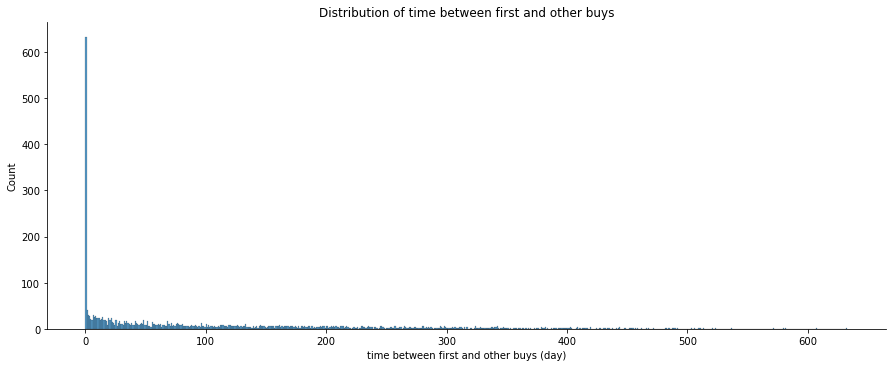

In [154]:
# распределение в днях 
second_buys['time_after_first_buy_days'] = second_buys.time_after_first_buy.dt.days

fig1 = sns.displot(second_buys, x='time_after_first_buy_days', bins=634, height=5, aspect=2.5) \
    .set(xlabel = 'time between first and other buys (day)',
         title = 'Distribution of time between first and other buys') 

Как видно из распределения по дням, большое количество вторых (и последующих) покупок происходит в течение суток после первой покупки. Посмотрим распределение по часам при разнице между покупками менее 1 дня:

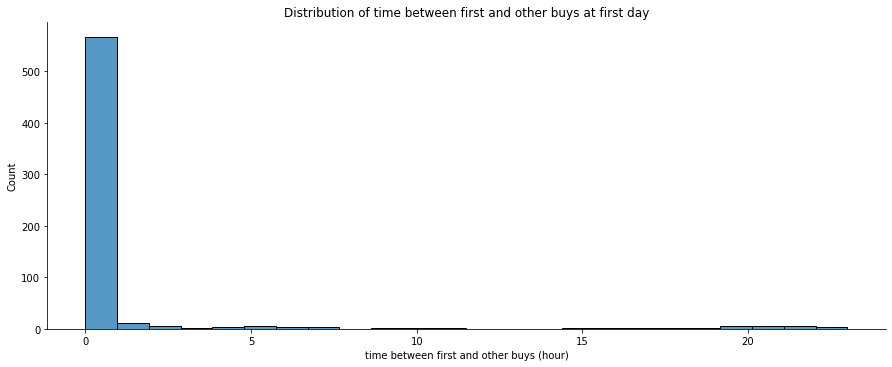

In [155]:
td_one_day = second_buys \
    .copy() \
    .query('time_after_first_buy_days == 0')
td_one_day['time_after_first_buy_hours'] = td_one_day.time_after_first_buy.dt.components['hours']
fig2 = sns.displot(td_one_day, x='time_after_first_buy_hours', bins=24, height=5, aspect=2.5) \
    .set(xlabel ='time between first and other buys (hour)',
         title = 'Distribution of time between first and other buys at first day') 

И снова, как и в распределении по дням видно, что поавляющее большинство покупок было совершено в первый час. Причем в последующее время количество повторных покупок падает на 2 порядка... Рассмотрим поближе эти повторные покупки:

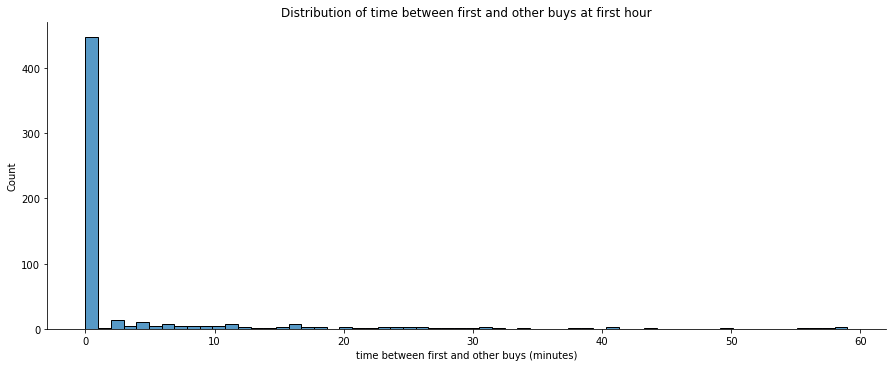

In [156]:
td_one_hour = td_one_day \
    .copy() \
    .query('time_after_first_buy_hours == 0')
td_one_hour['time_after_first_buy_minutes'] = td_one_hour.time_after_first_buy.dt.components['minutes']
fig3 = sns.displot(td_one_hour, x='time_after_first_buy_minutes', bins=60, height=5, aspect=2.5) \
    .set(xlabel ='time between first and other buys (minutes)',
         title = 'Distribution of time between first and other buys at first hour') 

Тут мы также видим аналогичную двум предыдущим рисункам картину: большая часть повторных покупок сделана в первую минуту после первой покупки. И если гистограмма распределения времени между 2-60 минутами выглядят стахастично, что мне кажется как-то отражает поведение живых людей, то выброс на первой минуте похож на что-то странное.

Для полноты картины исследуем последнюю минуту:

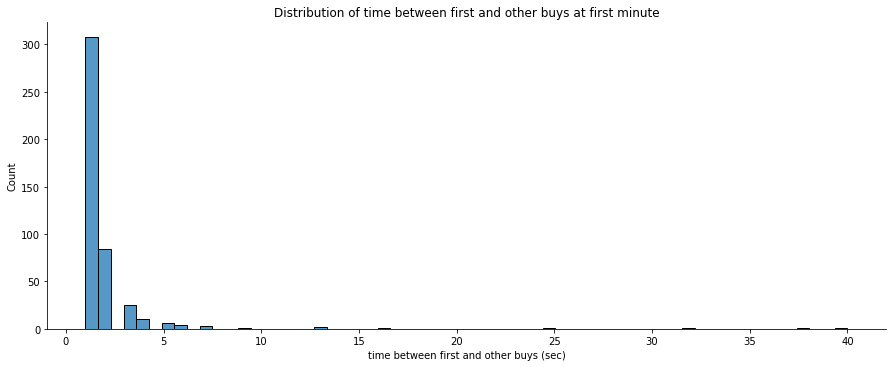

In [157]:
td_one_minute = td_one_hour \
    .copy() \
    .query('time_after_first_buy_minutes == 0')
td_one_minute['time_after_first_buy_sec'] = td_one_hour.time_after_first_buy.dt.components['seconds']

fig4 = sns.displot(td_one_minute, x='time_after_first_buy_sec', bins=60, height=5, aspect=2.5) \
    .set(xlabel ='time between first and other buys (sec)',
         title = 'Distribution of time between first and other buys at first minute') 

Как видно из последнего графика, **~400** повторных покупок происходит в первые 5 секунд после первой покупки, что составляет 400/2900 = **~14%**  от всех покупок после первой. Почему это происходит? нужны дополнительные данные. Но я считаю, что учитывать эти значения при расчете retention rate - это переоценивать этот показатель относительно его реального значения.

Насколько можно сделать повторный заказ за время в 10, 20 и 30 секунд  - вопрос обсуждаемый. Но этих значений мало, а значит они будут вносить небольшую погрешность.

Таким образом для расчета retention rate будут браться повторные заказы, с разницей по времени между повторным и первым заказом **более 5 секунд**.

In [158]:
# Извлечем секунды из столбца TimeDelta ('time_after_first_buy'):
second_buys['time_after_first_buy_sec'] = second_buys.time_after_first_buy.dt.components['seconds']
# Отсортируем вторые (третьи и т.д) покупки по описанному выше критерию, 
# это и будет та выборка повторных заказов, с которой мы будем работать для расчета retention time
# Кроме того отсортируем по отчетному периоду
sorted_second_buys = second_buys \
    .copy() \
    .query('time_after_first_buy_sec > 5 and date_first_buy >= "2017-01-01" and date_first_buy < "2018-01-01"')
sorted_second_buys

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,date_first_buy,month,cohort,time_after_first_buy,time_after_first_buy_days,time_after_first_buy_sec
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-09-04 11:26:38,2017-09-01,2017-09,27 days 23:29:55,27,55
17,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,delivered,2018-01-02 19:00:43,2018-01-02 19:09:04,2018-01-03 18:19:09,2018-01-20 01:38:59,2018-02-06,6e26bbeaa107ec34112c64e1ee31c0f5,21381,rio de janeiro,RJ,2017-07-04 21:57:51,2017-07-01,2017-07,181 days 21:02:52,181,52
48,b2ae55d11609779855c398bc2bd74fd4,c9f8da8278a23eb777ede2591b9ad3ee,delivered,2017-05-27 16:15:38,2017-05-27 16:25:09,2017-05-29 13:09:24,2017-06-08 12:03:23,2017-06-29,c2551ea089b7ebbc67a2ea8757152514,44380,cruz das almas,BA,2017-05-14 20:28:25,2017-05-01,2017-05,12 days 19:47:13,12,13
61,a742e3a941299687aed413c581a7dce9,f1e6293b21eebd4e0cd6828301c669b1,delivered,2017-06-04 14:53:58,2017-06-06 13:10:20,2017-06-08 12:47:20,2017-06-19 18:03:57,2017-06-19,51838d41add414a0b1b989b7d251d9ee,13068,campinas,SP,2017-03-13 18:14:36,2017-03-01,2017-03,82 days 20:39:22,82,22
87,878d8b6c3b9905f2eb5fe9d390c4c7db,2a9fdcc4458df62d3e9fb21f7d3d9fb8,delivered,2018-01-28 00:12:00,2018-01-30 04:31:07,2018-02-05 19:48:59,2018-03-02 17:41:52,2018-02-22,2ae3c67452283d5a0d30b32e0d33296e,71505,brasilia,DF,2017-12-22 00:17:37,2017-12-01,2017-12,36 days 23:54:23,36,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91108,64a62eaae697d2b5002204677fb331cf,3ed8a6ccdee18adec7d692baa5e65230,delivered,2017-12-01 22:03:48,2017-12-01 22:13:22,2017-12-04 21:09:47,2017-12-14 16:10:38,2017-12-26,b698379306c3fad0ab64d82a63a770a2,13616,leme,SP,2017-11-17 19:45:25,2017-11-01,2017-11,14 days 02:18:23,14,23
92144,c46172d2acb91b47e43297edd9d8b3ed,0a6851c4607181b4a4a770cbe556b822,delivered,2018-01-20 22:09:34,2018-01-20 22:41:05,2018-01-23 00:23:41,2018-01-26 00:14:40,2018-02-09,82809cee3c35eb89b4dd4d2d1a22eedf,13040,campinas,SP,2017-02-07 12:47:52,2017-02-01,2017-02,347 days 09:21:42,347,42
92708,3b070195d0d1272935abef5e1dcf0c9e,a840877f90f9417d723052e6e2341d5c,delivered,2018-06-17 12:31:55,2018-06-17 12:58:39,2018-06-19 14:07:00,2018-06-25 21:46:54,2018-07-11,82532fe90a30190fdc4622143d41dc15,18800,piraju,SP,2017-07-23 15:18:30,2017-07-01,2017-07,328 days 21:13:25,328,25
94210,7ed696782f4472458c5f1fc95bf5d6ed,aeaac9ee4a3514cf3da5f8cb07eeec5f,delivered,2017-09-18 23:34:58,2017-09-18 23:50:21,2017-09-21 20:15:51,2017-10-02 11:07:46,2017-10-04,2cf396c9e24e7627ff042cccb209b9e6,18980,irape,SP,2017-08-10 18:16:59,2017-08-01,2017-08,39 days 05:17:59,39,59


In [159]:
# считаем кол-во покупок (кроме первой), приходящихся на период за который нужно рассчитать retention rate (90 дней),
# для каждого покупателя (customer_unique_id)
sorted_second_buys \
    .query('time_after_first_buy_days < 91') \
    .groupby('customer_unique_id', as_index = False) \
    .agg({'order_id' : 'count'}) \
    .sort_values('order_id')

,customer_unique_id,order_id
0,013f4353d26bb05dc6652f1269458d8d,1
381,a97d43b24d76819903192611aca17914,1
380,a944a93bfa1d65b1523c45f9ccb01ec0,1
379,a8df4001abe77cf8473902c2b7efe418,1
378,a8cb771f0d1d230407948d4ce2af5c3e,1
...,...,...
78,25a560b9a6006157838aab1bdbd68624,3
134,3e43e6105506432c953e165fb2acf44c,3
503,de34b16117594161a6a89c50b289d35a,4
40,12f5d6e1cbf93dafd9dcc19095df0b3d,4


Как видно из таблице выше, за 90 дней с момента первой покупки часть покупателей совершили одну покупку, а часть более 1. Если для расчета retention rate будем использовать количество покупок (order_id), то получим завышенный показатель retention rate. Но т.к. retention rate - это коэффициент удержания **клиентов**, в нашем случае покупателей, то **корректно для расчета retention rate использовать количество уникальных customer_unique_id, совершивших повторную покупку в течение 90 дней**

In [160]:
repeat_buy_at_cohort_0_90days = sorted_second_buys \
    .query('time_after_first_buy_days <= 90') \
    .groupby('cohort', as_index = False) \
    .nunique()
repeat_buy_at_cohort_0_90days[['cohort', 'order_id', 'customer_unique_id']]


,cohort,order_id,customer_unique_id
0,2017-01,18,12
1,2017-02,17,16
2,2017-03,33,30
3,2017-04,33,29
4,2017-05,54,51
5,2017-06,45,43
6,2017-07,51,45
7,2017-08,63,61
8,2017-09,77,70
9,2017-10,60,56


Таблица выше демонстрирует какова разница значений при подсчете уникальных заказов и уникальных покупателей и тем самым дополнительно иллюстрирует рассуждения выше.

In [161]:
# посчитаем повторные покупки для оставшихся временных интервалов: 1 месяц  [0-30 дней], 2 месяц [31-60 дней], 3 месяц [61 - 90 дней]
    # 1 месяц [0-30 дней] 
repeat_buy_at_cohort_0_30days = sorted_second_buys \
    .query('time_after_first_buy_days <= 30') \
    .groupby('cohort', as_index = False) \
    .nunique() \
    [['cohort', 'customer_unique_id']] \
    .rename(columns = {'customer_unique_id' : 'return_uniq_cust_0_30'})

    # 2 месяц [31-60 дней]
repeat_buy_at_cohort_31_60days = sorted_second_buys \
    .query('time_after_first_buy_days >= 31 and time_after_first_buy_days <= 60') \
    .groupby('cohort', as_index = False) \
    .nunique() \
    [['cohort', 'customer_unique_id']] \
    .rename(columns = {'customer_unique_id' : 'return_uniq_cust_31_60'})

    # 3 месяц [61 - 90 дней]
repeat_buy_at_cohort_61_90days = sorted_second_buys \
    .query('time_after_first_buy_days >= 61 and time_after_first_buy_days <= 90') \
    .groupby('cohort', as_index = False) \
    .nunique() \
    [['cohort', 'customer_unique_id']] \
    .rename(columns = {'customer_unique_id' : 'return_uniq_cust_61_90'})

In [162]:
# объединим таблицу с подсчетом повторных покупок в каждой когорте с таблицей с подсчетом количества покупателей всего в когорте:
for_retention = repeat_buy_at_cohort_0_90days[['cohort', 'customer_unique_id']] \
    .merge(count_cohort_customers, how = 'inner', on = 'cohort') \
    .rename(columns = {'customer_unique_id' : 'return_uniq_cust_0_90', 'count_customer_unique_id' : 'all_uniq_cust'}) \
    .merge(repeat_buy_at_cohort_0_30days, how = 'inner', on = 'cohort') \
    .merge(repeat_buy_at_cohort_31_60days, how = 'inner', on = 'cohort') \
    .merge(repeat_buy_at_cohort_61_90days, how = 'inner', on = 'cohort')
# посчитаем retention rate в %
for_retention['retention_rate_0_90days'] = for_retention.return_uniq_cust_0_90/for_retention.all_uniq_cust*100
for_retention['retention_rate_0_30days'] = for_retention.return_uniq_cust_0_30/for_retention.all_uniq_cust*100
for_retention['retention_rate_31_60days'] = for_retention.return_uniq_cust_31_60/for_retention.all_uniq_cust*100
for_retention['retention_rate_61_90days'] = for_retention.return_uniq_cust_61_90/for_retention.all_uniq_cust*100

In [163]:
#  для наглядности уберем вспомогательные столбцы, оставив только результат:
retention = for_retention[['cohort', 'retention_rate_0_30days', 'retention_rate_31_60days', 'retention_rate_61_90days', 'retention_rate_0_90days']]
retention.style.highlight_max(axis = 0)

,cohort,retention_rate_0_30days,retention_rate_31_60days,retention_rate_61_90days,retention_rate_0_90days
0,2017-02,0.680693,0.123762,0.185644,0.990099
1,2017-03,0.479425,0.239712,0.519377,1.198562
2,2017-04,0.664894,0.398936,0.221631,1.285461
3,2017-05,0.840580,0.434783,0.260870,1.478261
4,2017-06,0.625617,0.395127,0.460981,1.415871
5,2017-07,0.826226,0.213220,0.239872,1.199360
6,2017-08,0.690165,0.640868,0.197190,1.503574
7,2017-09,0.974269,0.399700,0.424681,1.748688
8,2017-10,0.716101,0.554401,0.069300,1.293601
9,2017-11,0.920810,0.311659,0.254994,1.430798


**Вывод:** самый высокий retention rate в течение **трех месяцев (0 - 90 дней)** с момента первой покупки наблюдается у когорты покупателей совершивших первую покупку в **сентябре 2017 года**.  Тем не менее самый высокий retention rate **в третьем месяце (61 - 90 дней)** после первой покупки наблюдается у когорты покупателей совершивших покупку в **марте 2017**.

## 2.6 RFM-сегментация пользователей

Сегментация пользователей очень важна по многим причинам. Мы получаем более глубокие знания о наших клиентах и можем адаптировать целевые маркетинговые кампании.

Таким образом цель сегментации - разделить пользователей на ряд понятных групп, для планирования более прицельных действий в отношении каждой группы.

Основой сегментации будет предварительное ранжирование пользователей по трем признакам: 
- Recency: насколько недавно была совершена последняя покупка клиента;
- Frequency: как часто клиент совершает покупку;
- Monetary: сколько денег потратил клиент

### 2.6.1 Сегментация по Recency

In [164]:
#  Определим диапазон дат для анализа по первой и последней дате заказа:
first_day = orders.order_purchase_timestamp.min()  #первая дата
first_day

Timestamp('2016-09-04 21:15:19')

In [165]:
last_day = orders.order_purchase_timestamp.max() #последняя дата
last_day

Timestamp('2018-10-17 17:30:18')

In [166]:
# Зададимся датой, от которой будем отсчитывать период Recency. Это будет дата создания последнего заказа + 1 день:
now = last_day + timedelta(days=1)
now

Timestamp('2018-10-18 17:30:18')

Определим интервал времени прошедший с даты заказа последней покупки для каждого покупателя (customer_unique_id): как и ранее для этого фильтруем по статусу заказа **delivered**.

У нас уже есть подходящий для обработки DF: объединенные customers и orders с необходимым фильтром - **orders_merged**

In [167]:
#  определим дату заказа последней покупки:
last_buy = orders_merged \
    .groupby('customer_unique_id', as_index = False) \
    .agg({'order_purchase_timestamp' : 'max'})

# определим интервал времени прошедший с now до даты заказа последней покупки
last_buy['recency'] = now - last_buy.order_purchase_timestamp
last_buy['recency_days'] = last_buy['recency'].dt.days
last_buy.sort_values('recency')

,customer_unique_id,order_purchase_timestamp,recency,recency_days
13430,24ac2b4327e25baf39f2119e4228976a,2018-08-29 15:00:37,50 days 02:29:41,50
66809,b701bebbdf478f5500348f03aff62121,2018-08-29 14:52:00,50 days 02:38:18,50
46730,7febafa06d9d8f232a900a2937f04338,2018-08-29 14:18:28,50 days 03:11:50,50
33806,5c58de6fb80e93396e2f35642666b693,2018-08-29 14:18:23,50 days 03:11:55,50
44582,7a22d14aa3c3599238509ddca4b93b01,2018-08-29 12:25:59,50 days 05:04:19,50
...,...,...,...,...
49401,87776adb449c551e74c13fc34f036105,2016-10-03 22:31:31,744 days 18:58:47,744
51390,8d3a54507421dbd2ce0a1d58046826e0,2016-10-03 22:06:03,744 days 19:24:15,744
35804,61db744d2f835035a5625b59350c6b63,2016-10-03 21:13:36,744 days 20:16:42,744
17357,2f64e403852e6893ae37485d5fcacdaf,2016-10-03 16:56:50,745 days 00:33:28,745


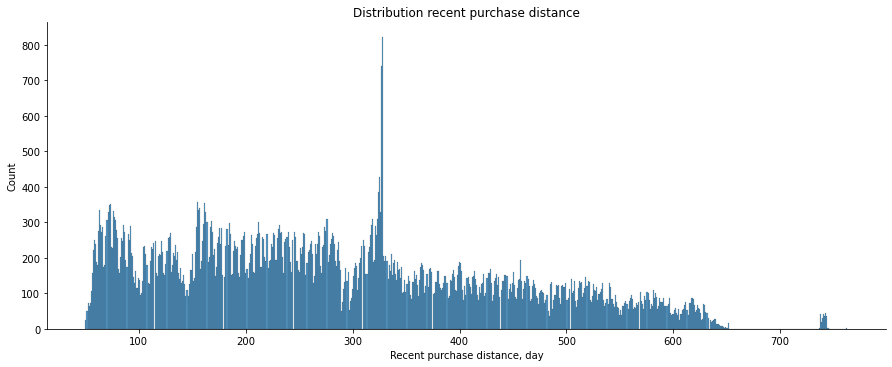

In [168]:
# посмотрим на распределение времени прошедшего от последней покупки клиента
fig6 = sns.displot(last_buy, x='recency_days',  height=5, bins=724, aspect=2.5) \
    .set(xlabel ='Recent purchase distance, day',
         title = 'Distribution recent purchase distance') 

Из распределения можно увидеть:
 - распределение достаточно равномерное, но явно убывающее при увеличении количества дней (что неудивительно, при когортном анализе мы видели что кол-во новых клиентов со временем в целом растет: см. когортный анализ)
 - в распределении есть явный максимум около 325 дней (**заказ подарков на день благодарения?**)
 
 - кроме того есть явные регулярные провалы с приблизительным интервалом в 60 дней.
    
Распределение равномерное, возможно хорошим вариантом при ранжировании будет разбить его по квантилям:

In [169]:
#  деление интервала значений от 50 до 764 дней с помощью квантилей:
quantiles_r = last_buy['recency'].quantile([0.2, 0.4, 0.6, 0.8])
quantiles_r

0.2   141 days 20:00:10
0.4   226 days 20:18:21
0.6   317 days 19:44:48
0.8   431 days 18:56:09
Name: recency, dtype: timedelta64[ns]

In [170]:
#  функция для ранжирования recency:
def rang_recency(recency):
    if recency <= quantiles_r[0.2]:
        return 1
    elif recency <= quantiles_r[0.4]:
        return 2
    elif recency <= quantiles_r[0.6]:
        return 3
    elif recency <= quantiles_r[0.8]:
        return 4
    else:
        return 5        

In [207]:
#  ранжируем
last_buy['R'] = last_buy['recency'].apply(lambda x: rang_recency(x))
last_buy

,customer_unique_id,order_purchase_timestamp,recency,recency_days,R
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,161 days 06:33:51,161,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,164 days 06:18:51,164,2
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,586 days 20:25:15,586,5
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,370 days 21:00:37,370,4
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,337 days 21:44:36,337,4
...,...,...,...,...,...
93331,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,496 days 20:29:42,496,5
93332,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,311 days 21:22:22,311,3
93333,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,618 days 01:41:02,618,5
93334,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,169 days 02:12:37,169,2


<AxesSubplot:xlabel='R', ylabel='Count'>

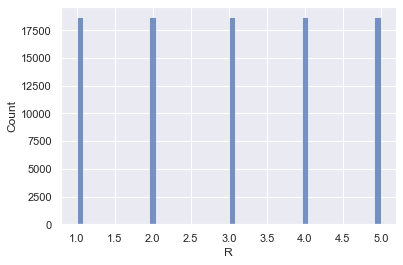

In [208]:
sns.histplot(data = last_buy, x = "R")

### 2.6.2 Сегментация по Frequency

В разделе, посвященном когортному анализу обнаружилось большое количество заказаов, сделанных спустя менее 5 секунд от предыдущего. На мой взгляд такие заказы не стоит учитывать при подсчете общего количества заказов.

Так, что для начала определимся со временем прошедшим со времени предыдущего заказа:

In [214]:
# определим дату предыдущей покупки:
orders_merged['lagged_order_purchase_timestamp'] = (orders_merged.sort_values(by=['order_purchase_timestamp'], ascending=True) \
                                                    .groupby(['customer_unique_id'])['order_purchase_timestamp'] \
                                                    .shift(1))

# определим разницу во времени заказа между текущим заказом и предыдущим в секундах
orders_merged['time_between_current_and_previous_buys'] = (orders_merged['order_purchase_timestamp'] - orders_merged['lagged_order_purchase_timestamp']) \
    .dt.components['seconds']

# уберем из DF покупки, заказы которых сделаны через менее 5 сек от предыдущего заказа (будем эти покупки учитыватьь как одну), 
# причем оставим те, покупки у кого разница во времени неопределена (первые и/или единственные заказы) 
for_frequency = orders_merged.query('(time_between_current_and_previous_buys > 5) | time_between_current_and_previous_buys.isnull()', engine='python') \
    [['customer_unique_id', 
       'order_id', 
       'order_purchase_timestamp', 
       'lagged_order_purchase_timestamp', 
       'time_between_current_and_previous_buys']]

# это и будет наш DF для подсчета frequency
for_frequency

,customer_unique_id,order_id,order_purchase_timestamp,lagged_order_purchase_timestamp,time_between_current_and_previous_buys
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-09-04 11:26:38,55.0
1,7c396fd4830fd04220f754e42b4e5bff,69923a4e07ce446644394df37a710286,2017-09-04 11:26:38,NaT,NaN
2,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,NaT,NaN
3,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,NaT,NaN
4,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,NaT,NaN
...,...,...,...,...,...
96450,6359f309b166b0196dbf7ad2ac62bb5a,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,NaT,NaN
96451,da62f9e57a76d978d02ab5362c509660,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,NaT,NaN
96452,737520a9aad80b3fbbdad19b66b37b30,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,NaT,NaN
96453,5097a5312c8b157bb7be58ae360ef43c,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,NaT,NaN


In [215]:
#  посчитаем количество доставленных покупок для каждого покупателя (customer_unique_id) за весь период
count_orders_for_frequency = for_frequency \
    .groupby('customer_unique_id', as_index = False) \
    .agg({'order_id' : 'count'}) \
    .rename(columns = {'order_id' : 'frequency'})
count_orders_for_frequency.sort_values('frequency')

,customer_unique_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
61921,a9a8e12cff7baec85574adf13b864f86,1
61920,a9a852a3533326b04e1e7e9bfac1f0a2,1
61919,a9a8393b0b0268c74e2b0a567da9166a,1
61918,a9a7ad094e7f664ee17a02d45257ddfd,1
...,...,...
22774,3e43e6105506432c953e165fb2acf44c,6
87864,f0e310a6839dce9de1638e0fe5ab282a,6
73905,ca77025e7201e3b30c44b472ff346268,7
36700,6469f99c1f9dfae7733b25662e7f1782,7


In [174]:
# попытаемся отранжировать по квантилям:
quantile_f = count_orders_for_frequency.quantile([0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.975, 0.98, 0.995, 0.997, 0.998, 0.999])
quantile_f

,frequency
0.200,1.0
0.400,1.0
0.600,1.0
0.800,1.0
0.900,1.0
0.950,2.0
0.975,2.0
0.980,2.0
0.995,4.0
0.997,5.0


Ранжировать по квантилям для frequency вероятно не получится, ~ 97.5%  покупателей  сделали только 1 покупку, ~2.5%  - две и более покупок и только 0.1% - 3 и более покупок. Причем есть покупатели совершившие 6 - 14 покупок.

Проще ранжировать следующим образом:


**3** - 1 покупку;

**2** - 2-6 покупки;

**1** - 7 и более покупок.

In [216]:
#  функция для ранжирования frequency:
def rang_frequency(frequency):
    if frequency <= 1:
        return 3
    elif frequency <= 6:
        return 2
    else:
        return 1    

In [217]:
#  ранжируем
count_orders_for_frequency['F'] = count_orders_for_frequency['frequency'].apply(lambda x: rang_frequency(x))
count_orders_for_frequency.sort_values('frequency')

,customer_unique_id,frequency,F
0,0000366f3b9a7992bf8c76cfdf3221e2,1,3
61921,a9a8e12cff7baec85574adf13b864f86,1,3
61920,a9a852a3533326b04e1e7e9bfac1f0a2,1,3
61919,a9a8393b0b0268c74e2b0a567da9166a,1,3
61918,a9a7ad094e7f664ee17a02d45257ddfd,1,3
...,...,...,...
22774,3e43e6105506432c953e165fb2acf44c,6,2
87864,f0e310a6839dce9de1638e0fe5ab282a,6,2
73905,ca77025e7201e3b30c44b472ff346268,7,1
36700,6469f99c1f9dfae7733b25662e7f1782,7,1


### 2.6.2 Сегментация по Monetary

In [177]:
# подготовка DF 
for_monetary = items \
    .merge(orders_delivered_corrected, how = 'inner', on = 'order_id') \
    .merge(customers, how = 'inner', on = 'customer_id') \
    [['order_id', 
     'order_item_id', 
     'product_id', 
     'price', 
     'order_purchase_timestamp', 
     'customer_unique_id']]
for_monetary.head()

,order_id,order_item_id,product_id,price,order_purchase_timestamp,customer_unique_id
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5


In [178]:
cust_unique_id_sum_purchase = for_monetary \
    .groupby('customer_unique_id', as_index = False) \
    .agg({'price' : 'sum'}) \
    .rename(columns = {'price' : 'monetary'})
cust_unique_id_sum_purchase.sort_values('monetary')

,customer_unique_id,monetary
65539,b38211bd797f4fdd81a98b9d1754b606,0.85
78880,d80730c15c647bc8f2ad77c908ba5ca9,0.85
18098,317cfc692e3f86c45c95697c61c853a6,2.20
69014,bd06ce0e06ad77a7f681f1a4960a3cc6,2.29
75605,cf3839da0d9492ad151690b65f45d800,2.99
...,...,...
25431,459bef486812aa25204be022145caa62,6729.00
80444,dc4802a71eae9be1dd28f5d788ceb526,6735.00
43161,763c8b1c9c68a0229c42c9fc6f662b93,7160.00
79617,da122df9eeddfedc1dc1f5349a1a690c,7388.00


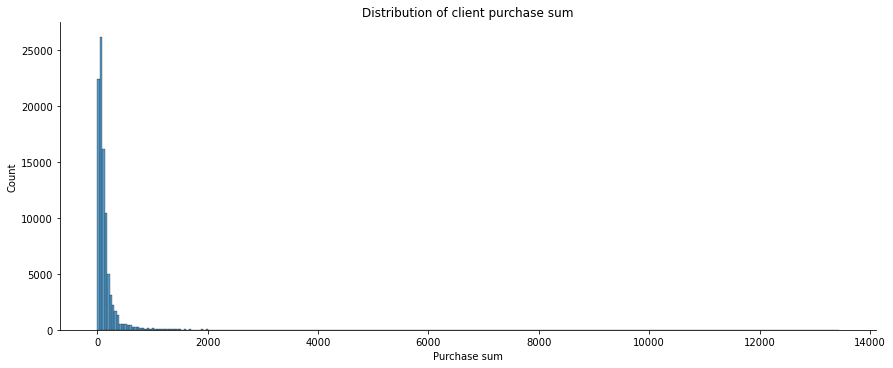

In [179]:
# посмотрим на распределение сумм покупок пользователей
fig5 = sns.displot(cust_unique_id_sum_purchase, x='monetary', bins=300, height=5, aspect=2.5) \
    .set(xlabel ='Purchase sum',
         title = 'Distribution of client purchase sum') 

In [180]:
#  попытаемся разделить интервал значений от 0.85 до 13440 с помощью квантилей:
quantiles_m = cust_unique_id_sum_purchase['monetary'].quantile([0.25, 0.5, 0.8, 0.9, 0.95, 0.99])
quantiles_m

0.25      47.65
0.50      89.70
0.80     179.90
0.90     279.99
0.95     419.87
0.99    1004.99
Name: monetary, dtype: float64

Как видно из таблицы, рисунка и разных квантилей:
    - распределение ассиметрично и достаточно узкое;
    - максимум смещен в сторону малых значений
    - кроме того неизветсно какую долю общей выручки приносят покупатели с большой суммой покупок
    
Чтобы оценить сколько приносят в кампанию покупатели с разной итоговой суммой покупок посмотрим на **взвешенную гистограмму**. В качестве весов будем использовать суммы покупок за весь период. Это позволит отценить долю выручки, которую приносит та или иная группа покупателей.

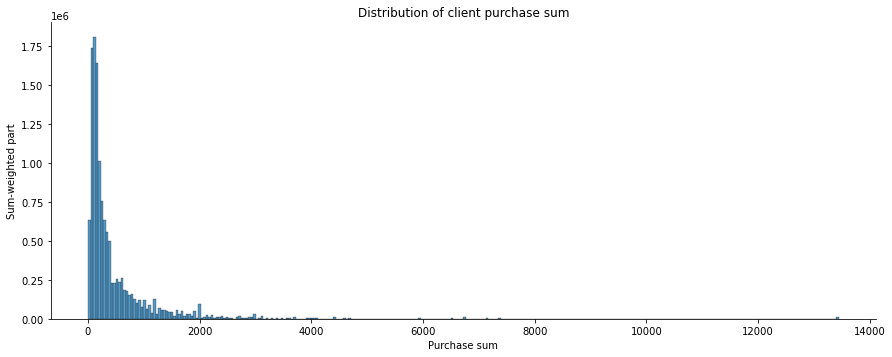

In [181]:
fig6 = sns.displot(cust_unique_id_sum_purchase, x='monetary', weights='monetary', bins=300, height=5, aspect=2.5) \
    .set(xlabel = 'Purchase sum',
         ylabel = 'Sum-weighted part',
         title = 'Distribution of client purchase sum') 

Взвешенная гистограмма показывает некоторые детали:
 - стало видно, что покупатели с суммой покупок за весь период более 4000 составляют малую долю в общей выручке кампании.
 - около 500 есть некоторый локальный максимум
 
 Но как-то все равно мало данных для принятия решения о ранжировании. Посмотрим на взвешенные кумулятивные графики распределения

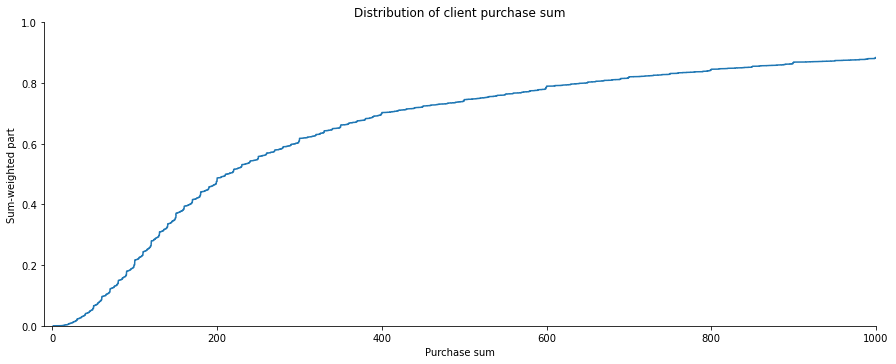

In [182]:
fig7 = sns.displot(cust_unique_id_sum_purchase, x='monetary',  weights='monetary', kind="ecdf", height=5, aspect=2.5) \
    .set(xlabel = 'Purchase sum',
         ylabel = 'Sum-weighted part',
         title = 'Distribution of client purchase sum',
        xlim = (-10, 1000),
        ylim = (0, 1)) 

Рассмотрим график выше. 

- на покупателей, сумма покупок которых менее медианного значения (**89.70**), приходится около 20% выручки кампании;
- ~40% выручки приносят покупатели, сумма покупок которых от 89.7 до 300;
- далее рост выручки с ростом суммы покупок замедляется и на покупателей сумма покупок которых от 300 до 500 приходится уже менее 20% выручки
- на покупателей с суммой покупок более 1000 приходится около 10 % выручки каампании

Предлагаю построить градацию на основе выручки которую приносят покупатели кампании:

**5** - до 20%, т.е. с суммой покупок до 89.70];

**4** - 20-40%, т.е. с суммой покупок (89.70 - 170];

**3** - 40-60%, т.е. с суммой покупок (170 - 300];

**2** - 60-80%, т.е. с суммой покупок (300 - 650];

**1** - более 80%, т.е. с суммой покупок более 650

In [183]:
#  функция для ранжирования monetary:
def rang_monetary(monetary):
    if monetary <= 89.70:
        return 5
    elif monetary <= 170:
        return 4
    elif monetary <= 300:
        return 3
    elif monetary <= 650:
        return 2
    else:
        return 1    

In [184]:
cust_unique_id_sum_purchase['M'] = cust_unique_id_sum_purchase['monetary'].apply(lambda x: rang_monetary(x))
cust_unique_id_sum_purchase

,customer_unique_id,monetary,M
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,5
2,0000f46a3911fa3c0805444483337064,69.00,5
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,5
4,0004aac84e0df4da2b147fca70cf8255,180.00,3
...,...,...,...
93331,fffcf5a5ff07b0908bd4e2dbc735a684,1570.00,1
93332,fffea47cd6d3cc0a88bd621562a9d061,64.89,5
93333,ffff371b4d645b6ecea244b27531430a,89.90,4
93334,ffff5962728ec6157033ef9805bacc48,115.00,4


### 2.6.3 Сборка итогового DF для RFM-сегментации

In [218]:
rfm = last_buy[['customer_unique_id', 'R']] \
    .merge(count_orders_for_frequency[['customer_unique_id', 'F']], how = 'inner', on = 'customer_unique_id') \
    .merge(cust_unique_id_sum_purchase[['customer_unique_id', 'M']], how = 'inner', on = 'customer_unique_id')
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm

,customer_unique_id,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,2,3,4,234
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2,3,5,235
2,0000f46a3911fa3c0805444483337064,5,3,5,535
3,0000f6ccb0745a6a4b88665a16c9f078,4,3,5,435
4,0004aac84e0df4da2b147fca70cf8255,4,3,3,433
...,...,...,...,...,...
93331,fffcf5a5ff07b0908bd4e2dbc735a684,5,3,1,531
93332,fffea47cd6d3cc0a88bd621562a9d061,3,3,5,335
93333,ffff371b4d645b6ecea244b27531430a,5,3,4,534
93334,ffff5962728ec6157033ef9805bacc48,2,3,4,234


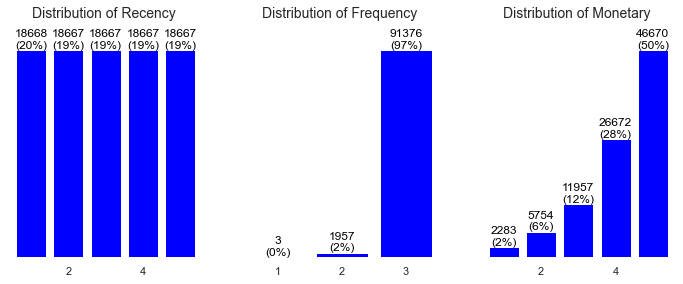

In [220]:
# посмотрим на распределение по рангам

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for i, p in enumerate(['R', 'F', 'M']):
    parameters = {'R':'Recency', 'F':'Frequency', 'M' : 'Monetary'}
    # y = rfm[p].value_counts().sort_index()
    y = rfm.groupby(p).agg({'customer_unique_id' : 'count'}).sort_index()['customer_unique_id']
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='blue')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {} \n'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='bottom',
               color='black')

plt.show()


На данном рисунке видно:
- абсолютно равномерное распределение Recency, что не удивительно т.к. мы разбивали по квартилям
- распределения Frecuency и Monetary ассиметричны, с выраженными максимумами в максимальных группах. В распределении Frecuency это обусловлено поведением покупателей, т.к. 97% совершили только 1 покупку. Распределение Monetary также ассиметрично по количеству, но каждая из групп приносит ~20% выручки.

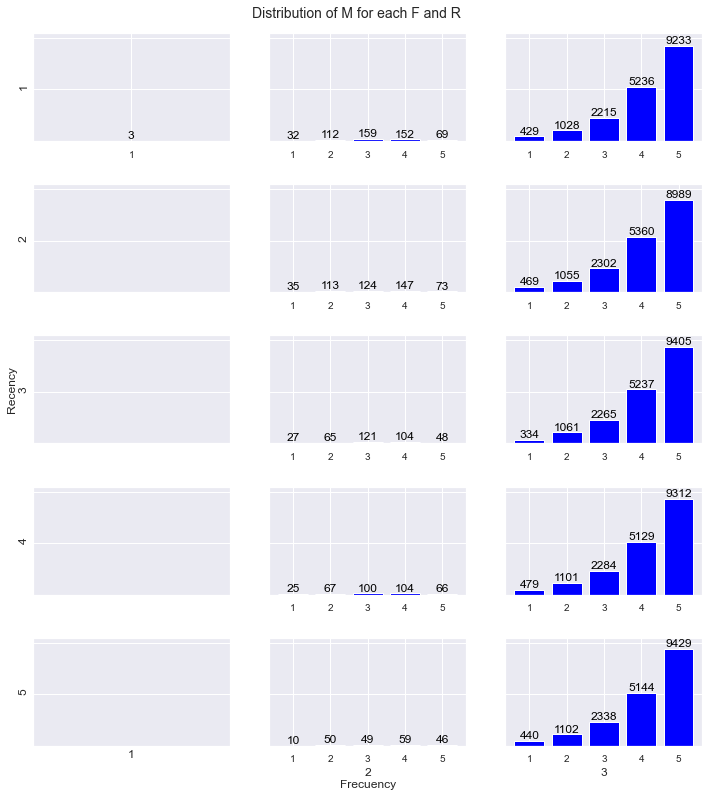

In [221]:
# Посмотрим на распредление Monetary в зависимости от Recency и Frecuency
fig, axes = plt.subplots(nrows=5, ncols=3,
                         sharex=False, sharey=True,
                         figsize=(12, 12))
r_range = range(1, 6)
f_range = range(1, 4)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='blue')
        if r == 5:
            if f == 2:
                ax.set_xlabel('{}\nFrecuency'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('Recency\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(True)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=10)
        ax.set_ylim(0, 10500)

        for bar in bars:
            value = bar.get_height()
#             if value == y.max():
#                 bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='black')
fig.subplots_adjust(hspace=0.4, top=0.95)
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.show()

### Рассмотрим зависимость Monetary от Recency и Frecuency, на графиках заметно:
- среди покупателей совершивших одну покупку наиболее ярко выражена по количеству группа тех кто совершил покупки на небольшие суммы (5 группа Monetary) вне зависимости от того насколько недавно это произошло.
- среди покупателей совершивших от 2 до 6 покупок максимум распределения по Monetary смещается к 3-4 группе.
- количество (и доля) покупателей совершивших 2-6 покупок монотонно растет при переходе от 5 группы Recency к 1 группе (это неплохо!)
- среди тех кто совершил 7 и более покупок всего 3 покупателя, но стоит отметить, что все эти покупатели принесли большую выручку, и сделали это недавно 

Еще более огрублять ранжирование Frecuency до 2х групп (1 покупка; 2 и более покупки) считаю нерациональным, слишком упрощающим этот показатель. 

Так как целью RFM-сергментации является разделение покупателей на понятные сегменты будем проводить сегментацию на основе всех **трех признаков**.  

Разбиение на сегменты на основании RFM-рангов очень субьективно и как мне представлется должно обсуждаться на разных уровнях и в разных отделах кампании. Предлагаю свой вариант:

1. **R(1), F(3), M(3-5)** - ordinary new customers (обычные новые покупатели, недавно совершившие первую покупку на среднюю или небольшую сумму)
2. **R(1), F(3), M(1-2)** - important new customers (новые покупатели, недавно совершившие первую покупку на большую сумму)
3. **R(2), F(3), M(any)** - promising customers (новые покупатели, совершившие первую покупку относительно недавно)
4. **R(1), F(1-2), M(1-2)** - champions (покупатели совершающие покупки часто, недавно и много)
5. **R(1-2), F(1-2), M(3-5) и R(2), F(1-2), M(1-2)** - loyal customers (лояльные покупатели, покупавшие недавно несколько раз)
6. **R(3-4), F(1-2), M(any) и R(3-4), F(3), M(1-2)** - need attention (покупатели, которые давно не покупали или покупали 1 раз, но на большую сумму)
7. **R(3-5), F(3), M(3-5) и R(5), F(3), M(1-2) и R(5), F(1-2), M(4-5)** -  hibernating (покупатели, которые совершили 1 покупку давно или несколько покупок давно и на небольшую или среднюю сумму)
8. **R(5), F(1), M(1)** - сan’t lose them (покупатели совершившие несколько покупок на очень крупную сумму очень давно)
9. **R(5), F(2), M(1-3) и R(5), F(1), M(2-3)** - at risk (покупатели совершившие несколько покупок на достаточно крупную сумму очень давно)

In [222]:
# исходя из описанных выше сегментов составляем словарь для сегментации RFM-рангов
segt_map = {
    r'13[3-5]' : 'ordinary new customers',
    r'13[1-2]' : 'important new customers',
    r'23.' : 'promising customers',
    r'1[1-2][1-2]' : 'champions',
    r'[1-2][1-2][3-5]' : 'loyal customers',
    r'2[1-2][1-2]' : 'loyal customers',
    r'[3-4][1-2].' : 'need attention',
    r'[3-4]3[1-2]' : 'need attention',
    r'[3-5]3[3-5]' : 'hibernating',
    r'53[1-2]' : 'hibernating',
    r'5[1-2][4-5]' : 'hibernating',
    r'511' : 'сan’t lose them',
    r'52[1-3]' : 'at risk',
    r'51[2-3]' : 'at risk'
}

In [223]:
rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,customer_unique_id,R,F,M,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,2,3,4,234,promising customers
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2,3,5,235,promising customers
2,0000f46a3911fa3c0805444483337064,5,3,5,535,hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,4,3,5,435,hibernating
4,0004aac84e0df4da2b147fca70cf8255,4,3,3,433,hibernating


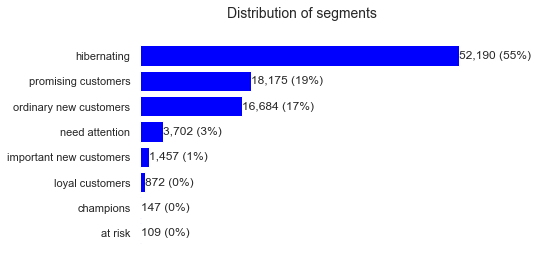

In [224]:
# Посмотрим на распределение покупателей по сегментам 

segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='blue')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

fig.suptitle('Distribution of segments',
             fontsize=14)
        
plt.show()

# , height=5, aspect=2.5 displot

### Выводы

1. Более половины клиентов нашей кампании делали покупки очень давно (**'hibernating'** и **'at risk'**).
2. Доля лояльных клинетов и чемпионов составляет менее 1%.
3. Доля новых покупателей (**'ordinary new customers'** и **'important new customers'**) и покупателей сделавших покупку недавно (**'promising customers'**) достаточно велика (примерно ~19% в каждой группе и 38% суммарно)
4. Из отношения количества новых/недавних покупателей к лояльным можно сделать вывод, что вероятность перехода покупателя из сегмента "новый покупатель" в сегмент "лояльный" низка.
5. Также хотелось бы обратить внимание на сегмент **'at risk'**. Покупателей в этих сегментах немного, но очень давно они совершили покупку на крупные суммы и не хотелось бы терять этих покупателей
6. Также стоит обратить внимание на сегмент **'need attention'** в котором представлены покупатели  вышедшие из сегмента **'loyal customers'** и **'important new customers'**.